Diff expression analysis for SKG High v SKG Low with MAST for single cell RNA sequencing data for SKG mice Rheumatoid Arthritis Project

Last Updated on: August 12, 2021

# Import Libraries

In [1]:

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
#import seaborn as sb
#from gprofiler import GProfiler

#import rpy2.rinterface_lib.callbacks
import logging
#import rpy2
#from rpy2.robjects import pandas2ri
import anndata2ri


In [2]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter


In [3]:
import rpy2
rpy2.__version__

'3.3.2'

In [53]:
anndata2ri.__version__

'1.0.4'

In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
#rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures


In [6]:
%%R

# Load all the R libraries we will be using in the notebook

library(MAST)


R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find

In [51]:
%%R
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /wynton/home/ye/emccarthy/miniconda3/envs/mast/lib/libmkl_rt.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Matrix_1.2-18               MAST_1.12.0                
 [3] SingleCellExperiment_1.8.0  SummarizedExperiment_1.16.1
 [5] DelayedArray_0.12.3         BiocParallel_1.20.1        
 [7] matrixStats_0.57.0          Biobase_2.46.0             
 [9] GenomicRanges_1

# Load Data

In [7]:

path = 'adata_object/'
adata_file = path + 'adata_only_T_cells.h5ad'
adata = sc.read(adata_file)
print("done")

done


# Remove Dual TRA cells

In [8]:
adata = adata[adata.obs['TRBV'] != 'None']
adata = adata[["_" not in x for x in list(adata.obs['TRAV'])]]
adata

/wynton/home/ye/emccarthy/miniconda3/envs/mast/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 71590 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
adata.obs['mouse'] = [str(x) for x in adata.obs['mouse']]

Trying to set attribute `.obs` of view, copying.


# Subset adata to SKG TRBV3 cells

In [10]:
gene = 'TRBV3'
adata.obs[gene] = [x == gene for x in adata.obs['TRBV']]

In [11]:
adata_subset = adata[[x in  ["SKG_High","SKG_Low"] for x in adata.obs['subgroup']]]

In [12]:
gene = 'TRBV3'
adata_subset = adata_subset[adata_subset.obs[gene] == True]

/wynton/home/ye/emccarthy/miniconda3/envs/mast/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [13]:
adata_subset

View of AnnData object with n_obs × n_vars = 1033 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype', 'TRBV3'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [14]:
np.unique(adata_subset.obs['leiden'], return_counts = True)

(array(['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
       dtype=object),
 array([161,  91,  22,  13,  11, 141, 108,  73, 101,  87,  85, 109,  31]))

In [15]:
groups, counts = np.unique([x + ":" + y for x,y in zip(adata_subset.obs['leiden'], adata_subset.obs['subgroup'])], return_counts = True)
for x,y in zip(groups, counts):
    print(x,y)

0:SKG_High 137
0:SKG_Low 24
10:SKG_High 19
10:SKG_Low 3
11:SKG_High 12
11:SKG_Low 1
12:SKG_High 10
12:SKG_Low 1
1:SKG_High 68
1:SKG_Low 23
2:SKG_High 116
2:SKG_Low 25
3:SKG_High 92
3:SKG_Low 16
4:SKG_High 65
4:SKG_Low 8
5:SKG_High 81
5:SKG_Low 20
6:SKG_High 74
6:SKG_Low 13
7:SKG_High 83
7:SKG_Low 2
8:SKG_High 100
8:SKG_Low 9
9:SKG_High 25
9:SKG_Low 6


# Set up adata object for MAST

In [16]:
adata_subset.obs['n_genes'] = (adata_subset.raw.X > 0).sum(1)

Trying to set attribute `.obs` of view, copying.


In [17]:
skg_dict = {'SKG_Low':0,"SKG_High":1}
adata_subset.obs['SKG_high'] = [skg_dict[x] for x in adata_subset.obs['subgroup']]

In [18]:
adata_test = sc.AnnData(X=adata_subset.raw.X, var=adata_subset.raw.var, obs = adata_subset.obs)

# Run MAST for TRBV3

In [19]:
%%R -i adata_test -o result_tp

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca))

print("")

sca_filt = sca[rowSums(assay(sca)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_filt))


#Define & run hurdle model 
zlmCond_tp <- zlm(formula = ~SKG_high + leiden + n_genes + mouse, sca=sca_filt)
summaryCond_tp <- summary(zlmCond_tp, doLRT='SKG_high')
summaryDt_tp <- summaryCond_tp$datatable

result_tp <- merge(summaryDt_tp[contrast=='SKG_high' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_tp[contrast=='SKG_high' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_tp <- result_tp[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]



R[write to console]: `fData` has no primerid.  I'll make something up.

R[write to console]: `cData` has no wellKey.  I'll make something up.

R[write to console]: Assuming data assay in position 1, with name X is log-transformed.



[1] "Dimensions before subsetting:"
[1] 16666  1033
[1] ""
[1] "Dimensions after subsetting:"
[1] 12530  1033


R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   0% with 0 failures
R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   2% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   4% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   5% with 0 failures
R[write to console]: 
R[

# Save results

In [20]:
result_tp

,primerid,Pr(>Chisq),coef,FDR
1,0610009B22Rik,0.043928,-0.029593,0.137500
2,0610009O20Rik,0.116499,0.050163,0.265651
3,0610010F05Rik,0.490539,NaN,0.681501
4,0610010K14Rik,0.091789,-0.031924,0.228657
5,0610012G03Rik,0.565066,0.025530,0.743180
...,...,...,...,...
12526,mt-Nd3,0.019128,0.025905,0.078137
12527,mt-Nd4,0.392331,-0.022862,0.596230
12528,mt-Nd4l,0.010802,-0.117759,0.052563
12529,mt-Nd5,0.181687,0.078818,0.358003


In [21]:
gene = 'TRBV3'
result_tp.to_csv('results/single_cell_RNA_seq/TCR/'+gene+"_MAST_SKG_high_v_SKG_low.csv")

# Volcano plot for TRBV3

In [5]:
gene = 'TRBV3'
data_to_plot = pd.read_csv('results/single_cell_RNA_seq/TCR/'+gene+"_MAST_SKG_high_v_SKG_low.csv", index_col = 0)

updated_p_values = np.array(data_to_plot['FDR'])
print(np.sum([x == 0 for x in updated_p_values]))
updated_p_values[[x == 0 for x in updated_p_values]] = 2.2250738585072014e-308
print(np.sum([x == 0 for x in updated_p_values]))

data_to_plot['FDR_upd'] = updated_p_values
data_to_plot['logpvalue'] = [-np.log10(x) for x in data_to_plot['FDR_upd']]

data_to_plot = data_to_plot.sort_values(by = 'coef')


0
0


In [6]:
import math
data_to_plot = data_to_plot[[not math.isnan(x) for x in data_to_plot['coef'] ]]

In [7]:
genes_to_label_list = pd.read_csv('results/single_cell_RNA_seq/TCR/volcano_plot_gene_list_to_label.csv')

In [8]:
list(genes_to_label_list['gene'])

['Thy1',
 'Pdlim4',
 'Crip1',
 'Rps12',
 'Il7r',
 'Rplp1',
 'Rpsa',
 'Cd5',
 'Cd6',
 'Ets1',
 'Id2',
 'Izumo1r',
 'Dtx1',
 'Ptpn6',
 'Il6st',
 'Tox',
 'Ptprc',
 'Nr4a1',
 'Jak3',
 'Foxo1',
 'Il17ra',
 'Jak1']

In [20]:
!pwd

/wynton/group/ye/emccarthy/EM/judy_proj/final_code


['Thy1', 'Gm10260', 'Pdlim4', 'Rps12', 'Crip1', 'Il7r', 'Rplp1', 'Rpsa', 'Nr4a1', 'Il17ra', 'Jak3', 'Foxo1', 'Ptprc', 'Tox', 'Jak1', 'Il6st', 'Dtx1', 'Izumo1r', 'Ptpn6', 'Id2', 'Ets1', 'Cd6', 'Cd5']


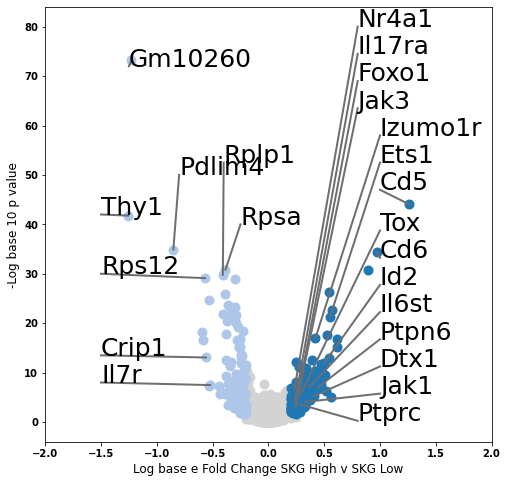

[42, 72, 50, 30, 13.5, 8, 52.5, 40]

In [26]:
from matplotlib import rc,rcParams
file_save_prefix = "results/single_cell_RNA_seq/TCR/"
rc('font', weight='bold')
color_values = {(True,True, True):"#1f77b4", (False, True, True): "#aec7e8"}
colors = [color_values.get((x > 0, abs(x) > 0.2, y > -np.log10(0.05)), "lightgrey") for x,y in zip(data_to_plot['coef'], data_to_plot['logpvalue'])]

fig = plt.figure(linewidth=3)


ax = fig.gca()
for color in ['lightgrey', "#1f77b4", "#aec7e8"]:
    subset_data = data_to_plot[[x == color for x in colors]]
    plt.scatter(list(subset_data['coef']),list(subset_data['logpvalue']), s = 25, edgecolors=color, color =  color)


plt.xlim((-2, 2)) 
plt.xlabel("Log base e Fold Change SKG High v SKG Low", size = 12)
plt.ylabel("-Log base 10 p value", size = 12)

# Label names and positions
x = [i for i in data_to_plot['coef']]
y = [i for i in data_to_plot['logpvalue']]
labels_orig = data_to_plot["primerid"]

genes_to_label = list(genes_to_label_list['gene']) +['Gm10260']

to_keep = np.where([i in genes_to_label for i in labels_orig])[0]
labels = list(np.array(labels_orig)[to_keep])
color_subset = list(np.array(colors)[to_keep])
print(labels)
x = list(np.array(x)[to_keep])
y = list(np.array(y)[to_keep])


top_value = 80
vert = [50,47,45,35,30,25,20,15,10] +[10]*14
left_genes = {'Thy1':'left', 'Pdlim4':'left', 'Crip1':'left', 'Rps12':'left', 'Il7r':'left', 'Rplp1':'left', 'Rpsa':'left'}
amt_horiz_dict = {"left":-1, "right":1}
amt_drop = -3

#[-1.2666404466485723,-1,
#  -0.8451907135327845,
#  -0.5849595655672271,
#  -0.5538512671985223,
#  -0.5204325514910555,
#  -0.4007468075009326,
#  -0.3725679416646823] 


x_coord = [-1.5,-1.25,-0.8, -1.5, -1.5, -1.5,-0.4007468075009326,-0.25]+ [0.8]*5 + [1]*10


#[60,80, 80-vert_change*1 ,80-vert_change*2 ,80-vert_change*3 ,
           #80-vert_change*4,80-vert_change*5,80-vert_change*6]
vert_change = 5.5
y_coord =  [42,72,50,30,13.5,8,80-vert_change*5,40 ]+[80, 80-vert_change*1,
80-vert_change*3,
80-vert_change*2,
80-vert_change*14.5,
80-vert_change*7.5,
80-vert_change*13.5,
           
80-vert_change*10.5,
80-vert_change*12.5,
80-vert_change*4,
80-vert_change*11.5, #7.5,
80-vert_change*9.5,
           
80-vert_change*5,
80-vert_change*8.5,
80-vert_change*6]


for i,txt in enumerate(labels):
    plt.plot([x[i],x_coord[i]],[y[i],y_coord[i]], color = "#6D6E71", linewidth = 2)
    t = plt.annotate(txt, (x_coord[i], y_coord[i]), size = 25, fontweight = 'normal')
             
    
plt.savefig(file_save_prefix + "TRBV3_SKG_high_v_SKG_low_volcano_plot_081921.svg", format="svg")

plt.show()
plt.close()


#'Nr4a1', 'Il17ra', 'Jak3', 'Foxo1', 'Ptprc', 'Tox', 'Jak1', 'Il6st', 'Dtx1', 'Izumo1r', 'Ptpn6', 'Id2', 'Ets1', 'Cd6', 'Cd5'
[0.2,]
[70,]

'Thy1', 'Gm10260', 'Pdlim4', 'Rps12', 'Crip1', 'Il7r', 'Rplp1', 'Rpsa'
[-1.5,-1.25,-0.8, -1.5, -1.5, -1.5,-0.4007468075009326,0]
[42,72,50,30,13.5,8,80-vert_change*5,40 ]

# Setup TRBV19 adata object for MAST

In [38]:
gene = 'TRBV19'
adata.obs[gene] = [x == gene for x in adata.obs['TRBV']]

adata_subset = adata[[x in  ["SKG_High","SKG_Low"] for x in adata.obs['subgroup']]]

adata_subset = adata_subset[adata_subset.obs[gene] == True]
print(adata_subset)

groups, counts = np.unique([x + ":" + y for x,y in zip(adata_subset.obs['leiden'], adata_subset.obs['subgroup'])], return_counts = True)
for x,y in zip(groups, counts):
    print(x,y)
    
adata_subset.obs['n_genes'] = (adata_subset.raw.X > 0).sum(1)

skg_dict = {'SKG_Low':0,"SKG_High":1}
adata_subset.obs['SKG_high'] = [skg_dict[x] for x in adata_subset.obs['subgroup']]

adata_test = sc.AnnData(X=adata_subset.raw.X, var=adata_subset.raw.var, obs = adata_subset.obs)

/wynton/home/ye/emccarthy/miniconda3/envs/mast/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 3580 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype', 'TRBV3', 'TRBV19'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
0:SKG_High 275
0:SKG_Low 312
10:SKG_High 36
10:SKG_Low 62
11:SKG_High 26
11:SKG_Low 31
12:SKG_High 12
12:SKG_Low 1
1:SKG_High 149
1:SKG_Low 382
2:SKG_High 225
2:SKG_Low 352
3:SKG_High 153
3:SKG_Low 140
4:SKG_High 121
4:SKG_Low 224
5:SKG_High 117
5:SKG_Low 191
6:SKG_H

# Run MAST for TRBV19

In [39]:
%%R -i adata_test -o result_tp

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca))

print("")

sca_filt = sca[rowSums(assay(sca)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_filt))


#Define & run hurdle model 
zlmCond_tp <- zlm(formula = ~SKG_high + leiden + n_genes + mouse, sca=sca_filt)
summaryCond_tp <- summary(zlmCond_tp, doLRT='SKG_high')
summaryDt_tp <- summaryCond_tp$datatable

result_tp <- merge(summaryDt_tp[contrast=='SKG_high' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_tp[contrast=='SKG_high' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_tp <- result_tp[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]



R[write to console]: `fData` has no primerid.  I'll make something up.

R[write to console]: `cData` has no wellKey.  I'll make something up.

R[write to console]: Assuming data assay in position 1, with name X is log-transformed.



[1] "Dimensions before subsetting:"
[1] 16666  3580
[1] ""
[1] "Dimensions after subsetting:"
[1] 13822  3580


R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   0% with 0 failures
R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   2% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   4% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   5% with 0 failures
R[write to console]: 
R[

In [40]:
gene = 'TRBV19'
result_tp.to_csv('results/single_cell_RNA_seq/TCR/'+gene+"_MAST_SKG_high_v_SKG_low.csv")

# Volcano plot for TRBV19

1
0
['Gm10260', 'Thy1', 'Pdlim4', 'Crip1', 'Rps12', 'Il7r', 'Rplp1', 'Rpsa', 'Jak3', 'Il17ra', 'Ptpn6', 'Tox', 'Jak1', 'Il6st', 'Ptprc', 'Nr4a1', 'Izumo1r', 'Foxo1', 'Dtx1', 'Id2', 'Ets1', 'Cd6', 'Cd5']


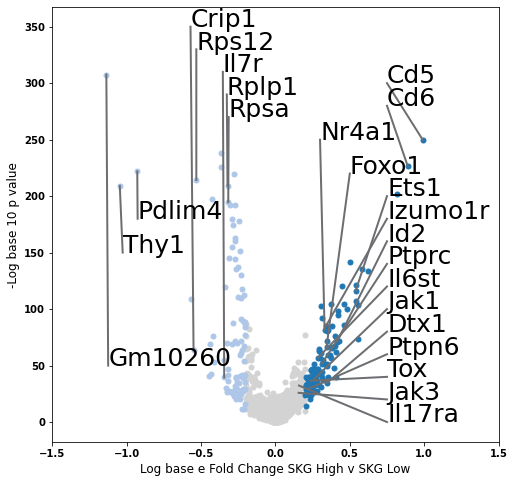

In [28]:
gene = 'TRBV19'
data_to_plot = pd.read_csv('results/single_cell_RNA_seq/TCR/'+gene+"_MAST_SKG_high_v_SKG_low.csv", index_col = 0)
updated_p_values = np.array(data_to_plot['FDR'])
print(np.sum([x == 0 for x in updated_p_values]))
updated_p_values[[x == 0 for x in updated_p_values]] = 2.2250738585072014e-308
print(np.sum([x == 0 for x in updated_p_values]))

data_to_plot['FDR_upd'] = updated_p_values


data_to_plot['logpvalue'] = [-np.log10(x) for x in data_to_plot['FDR_upd']]

data_to_plot = data_to_plot.sort_values(by = 'coef')
data_to_plot = data_to_plot[[not math.isnan(x) for x in data_to_plot['coef'] ]]

file_save_prefix = "results/single_cell_RNA_seq/TCR/"

color_values = {(True,True, True):"#1f77b4", (False, True, True): "#aec7e8"}
colors = [color_values.get((x > 0, abs(x) > 0.2, y > -np.log10(0.05)), "lightgrey") for x,y in zip(data_to_plot['coef'], data_to_plot['logpvalue'])]

for color in ['lightgrey', "#1f77b4", "#aec7e8"]:
    subset_data = data_to_plot[[x == color for x in colors]]
    plt.scatter(list(subset_data['coef']),list(subset_data['logpvalue']), s = 25, edgecolors=color, color =  color)

plt.xlim((-1.5, 1.5)) 
plt.xlabel("Log base e Fold Change SKG High v SKG Low", size = 12)
plt.ylabel("-Log base 10 p value", size = 12)
# Label names and positions
x = [i for i in data_to_plot['coef']]
y = [i for i in data_to_plot['logpvalue']]
labels_orig = data_to_plot["primerid"]

genes_to_label = list(genes_to_label_list['gene']) +['Gm10260']

to_keep = np.where([i in genes_to_label for i in labels_orig])[0]
labels = list(np.array(labels_orig)[to_keep])
color_subset = list(np.array(colors)[to_keep])
print(labels)
x = list(np.array(x)[to_keep])
y = list(np.array(y)[to_keep])


top_value = 80
vert = [50,47,45,35,30,25,20,15,10] +[10]*14
left_genes = {'Thy1':'left', 'Pdlim4':'left', 'Crip1':'left', 'Rps12':'left', 'Il7r':'left', 'Rplp1':'left', 'Rpsa':'left'}
amt_horiz_dict = {"left":-1, "right":1}
amt_drop = -3

# vert_coord = [18,21 ,24 , 60, 45, #1-5

x_coord = [-1.1238852479631882,-1.0263577268243462,
 -0.9259012965359751,
 -0.5704682246010042,
 -0.5313998102309863,
 -0.3531688974614524,
 -0.3265443842409699,
 -0.31400289724119546] + [0.75]*7 + [0.3] + [0.75]+[0.5]+[0.75]*5

vert_change = 20
y_coord = [50,150, 180,350, 350-vert_change*1,350-vert_change*2,350-vert_change*3,350-vert_change*4,

 vert_change*1,
 0,
vert_change*3,
vert_change*2,

 vert_change*5,
 vert_change*6,
 vert_change*7,
 250,
 vert_change*9,
 vert_change*11,
 vert_change*4,
 vert_change*8,
 vert_change*10,
 300-vert_change*1,
 300]

orig_x = list()
orig_y = list()
for i,txt in enumerate(labels):
    orig_x = orig_x + [x[i]]
    orig_y = orig_y + [y[i]]
    plt.plot([x[i],x_coord[i]],[y[i],y_coord[i]], color = "#6D6E71", linewidth = 2)
    t = plt.annotate(txt, (+x_coord[i], y_coord[i]), size = 25, fontweight = 'normal')


                           
    
plt.savefig(file_save_prefix + "TRBV19_SKG_high_v_SKG_low_volcano_plot_081921.svg", format="svg")

plt.show()
plt.close()